<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


<h1><center>Final Assignment</center></h1>


> ***Note: Please ensure you follow the instructions outlined in the in the <a href="https://www.coursera.org/learn/supervised-machine-learning-regression/supplement/YGZt9/project-scenario">Project Scenario</a> section to complete this Final Assignment successfully.***


In [246]:
!pip install kagglehub pandas numpy matplotlib scikit-learn

In [247]:
import kagglehub
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA

# 1. Dataset Description

**Dataset Name:** Student Habits vs. Academic Performance

**Hosted On:** Kaggle

**Link:** https://www.kaggle.com/datasets/jayaantanaath/student-habits-vs-academic-performance

**About the Dataset:**
This simulated dataset explores the impact of lifestyle habits on student academic performance. It comprises 1,000 synthetic student records, featuring over 15 attributes such as study hours, sleep patterns, social media usage, diet quality, mental health, and final exam scores. The dataset is ideal for machine learning projects, including regression analysis, clustering, and data visualization, as it was generated using realistic patterns for educational research.

In [248]:
path = Path(kagglehub.dataset_download("jayaantanaath/student-habits-vs-academic-performance"))
df = pd.read_csv(path/'student_habits_performance.csv')
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [249]:
df.describe()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score
count,1000.0000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.4980,3.55010,2.505500,1.819700,84.131700,6.470100,3.042000,5.438000,69.601500
std,2.3081,1.46889,1.172422,1.075118,9.399246,1.226377,2.025423,2.847501,16.888564
min,17.0000,0.00000,0.000000,0.000000,56.000000,3.200000,0.000000,1.000000,18.400000
25%,18.7500,2.60000,1.700000,1.000000,78.000000,5.600000,1.000000,3.000000,58.475000
50%,20.0000,3.50000,2.500000,1.800000,84.400000,6.500000,3.000000,5.000000,70.500000
75%,23.0000,4.50000,3.300000,2.525000,91.025000,7.300000,5.000000,8.000000,81.325000
max,24.0000,8.30000,7.200000,5.400000,100.000000,10.000000,6.000000,10.000000,100.000000


In [250]:
df.isnull().sum().sort_values(ascending=False)

parental_education_level         91
student_id                        0
gender                            0
age                               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
study_hours_per_day               0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64

We observed one column, 'student_id', lacking analytical significance, and another, 'parental_education_level', containing missing data. Additionally, the dataset includes several categorical columns: 'gender', 'part_time_job', and 'extracurricular_participation' are nominal, while 'diet_quality', 'parental_education_level', and 'internet_quality' are ordinal.

In [251]:
data = df.copy()

In [252]:
data = data.drop(['student_id'], axis=1)

In [253]:
data['parental_education_level'].unique()

array(['Master', 'High School', 'Bachelor', nan], dtype=object)

In [254]:
data[['parental_education_level']] = data[['parental_education_level']].fillna("Unknown")

The null values in 'parental_education_level' were imputed with "Unknown," converting it into a nominal variable to be encoded alongside other nominal categories.

In [255]:
nominal_columns = ['gender', 'part_time_job', 'extracurricular_participation', 'parental_education_level']
nominal_data = data[nominal_columns]
data = data.drop(nominal_columns, axis=1)

one_hot_nominal_data = pd.get_dummies(nominal_data, dtype="float64")
data = pd.concat([data, one_hot_nominal_data], axis=1)

In [256]:
ordinal_columns = ['diet_quality', 'internet_quality']
for column in ordinal_columns:
    print(column, data[column].unique())

diet_quality ['Fair' 'Good' 'Poor']
internet_quality ['Average' 'Poor' 'Good']


In [257]:
data[['diet_quality']] = OrdinalEncoder(categories=[['Poor', 'Fair', 'Good']]).fit_transform(data[['diet_quality']])
data[['internet_quality']] = OrdinalEncoder(categories=[['Poor', 'Average', 'Good']]).fit_transform(data[['internet_quality']])

In [258]:
int_columns = data.select_dtypes(['int64']).columns
data[int_columns] = data[int_columns].astype('float64')

In [259]:
print(df.columns.size, data.columns.size)
data.info()

16 22
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   1000 non-null   float64
 1   study_hours_per_day                   1000 non-null   float64
 2   social_media_hours                    1000 non-null   float64
 3   netflix_hours                         1000 non-null   float64
 4   attendance_percentage                 1000 non-null   float64
 5   sleep_hours                           1000 non-null   float64
 6   diet_quality                          1000 non-null   float64
 7   exercise_frequency                    1000 non-null   float64
 8   internet_quality                      1000 non-null   float64
 9   mental_health_rating                  1000 non-null   float64
 10  exam_score                            1000 non-null   float64
 11  gender_Femal

The data is now clean and prepared for analysis and regression modeling.

# 2. Analysis Objective

The primary objective of this regression analysis is to accurately predict student exam scores through the development and evaluation of multiple linear regression models. We will investigate various modeling techniques, including standard linear regression, LASSO, Ridge, and ElasticNet, to identify the most robust and predictive model. Furthermore, we will assess the impact of data scaling and advanced feature engineering techniques, such as polynomial features and Principal Component Analysis (PCA), on model performance. We will also analyze the most influential features in predicting student exam scores. Cross-validation will be extensively utilized to ensure the generalizability of our findings and to select the optimal model and hyperparameter settings for predicting student exam scores.

# 3. Model Comparison

In [260]:
X = data.drop(['exam_score'], axis=1)
y = data['exam_score']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)

In [261]:
def estimator_evaluation(estimator, name='Model', do_print=True, do_fit=True, do_return=False):
    if do_fit:
        estimator = estimator.fit(X_train, y_train)

    result = {
        'r2_train': r2_score(y_train, estimator.predict(X_train)),
        'r2_test': r2_score(y_test, estimator.predict(X_test))
    }
    if do_print:
        print(f"{name} - R2 Train: {result['r2_train']}")
        print(f"{name} - R2 Test: {result['r2_test']}")

    if do_return:
        return result

In [262]:
estimator_evaluation(LinearRegression(), "Standard Linear Regression")
estimator_evaluation(Lasso(), "LASSO Regression")
estimator_evaluation(Ridge(), "Ridge Regression")
estimator_evaluation(ElasticNet(), "ElasticNet Regression")


Standard Linear Regression - R2 Train: 0.9029717381660444
Standard Linear Regression - R2 Test: 0.8806849007044574
LASSO Regression - R2 Train: 0.8921851808184152
LASSO Regression - R2 Test: 0.8767039777400011
Ridge Regression - R2 Train: 0.9029714786068231
Ridge Regression - R2 Test: 0.8806727877152439
ElasticNet Regression - R2 Train: 0.8602780059008448
ElasticNet Regression - R2 Test: 0.8401102222077127


With default settings, multiple models achieved an R2 score of approximately 0.88 on the test set. We will first explore standard linear regression to determine the highest achievable R2 score.

In [263]:
estimator_evaluation(LinearRegression(), "Standard Linear Regression")
estimator_evaluation(
    Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    "Scaled Standard Linear Regression"
)
estimator_evaluation(
    Pipeline([
        ('polynomial', PolynomialFeatures(degree=2)),
        ('model', LinearRegression())
    ]),
    "Polynomial 2 Standard Linear Regression"
)
estimator_evaluation(
    Pipeline([
        ('polynomial', PolynomialFeatures(degree=2)),
        ('pca', PCA(0.99)),
        ('model', LinearRegression())
    ]),
    "PCA Polynomial 2 Standard Linear Regression"
)
estimator_evaluation(
    Pipeline([
        ('polynomial', PolynomialFeatures(degree=3)),
        ('model', LinearRegression())
    ]),
    "Polynomial 3 Standard Linear Regression"
)
estimator_evaluation(
    Pipeline([
        ('polynomial', PolynomialFeatures(degree=3)),
        ('pca', PCA(0.99)),
        ('model', LinearRegression())
    ]),
    "PCA Polynomial 3 Standard Linear Regression"
)

Standard Linear Regression - R2 Train: 0.9029717381660444
Standard Linear Regression - R2 Test: 0.8806849007044574
Scaled Standard Linear Regression - R2 Train: 0.9029717381660444
Scaled Standard Linear Regression - R2 Test: 0.8806849007044578
Polynomial 2 Standard Linear Regression - R2 Train: 0.9246489911952972
Polynomial 2 Standard Linear Regression - R2 Test: 0.8792210631373034
PCA Polynomial 2 Standard Linear Regression - R2 Train: 0.8888110433814518
PCA Polynomial 2 Standard Linear Regression - R2 Test: 0.8716160830774853
Polynomial 3 Standard Linear Regression - R2 Train: 0.9935203143386081
Polynomial 3 Standard Linear Regression - R2 Test: -2.857314678598184
PCA Polynomial 3 Standard Linear Regression - R2 Train: 0.7854785192111299
PCA Polynomial 3 Standard Linear Regression - R2 Test: 0.825304366036923


Standard linear regression (both scaled and unscaled) consistently yielded strong R2 test scores of approximately 0.881. Polynomial features of degree 2 showed a slight improvement in training R2 but indicated minor overfitting. Polynomial degree 3 models exhibited severe overfitting, resulting in negative test R2 scores, which signifies poor generalization. While PCA with polynomial degree 3 mitigated some overfitting, its performance remained subpar. Overall, standard linear regression proved to be the most effective.

Lasso Alpha 1e-05 Regression - R2 Train: 0.902971738160528
Lasso Alpha 1e-05 Regression - R2 Test: 0.8806849800576296
Lasso Alpha 4.641588833612782e-05 Regression - R2 Train: 0.9029717380467709
Lasso Alpha 4.641588833612782e-05 Regression - R2 Test: 0.8806852799967414
Lasso Alpha 0.00021544346900318823 Regression - R2 Train: 0.9029717355768395
Lasso Alpha 0.00021544346900318823 Regression - R2 Test: 0.8806866422523867
Lasso Alpha 0.001 Regression - R2 Train: 0.9029716834278715
Lasso Alpha 0.001 Regression - R2 Test: 0.880689806674425
Lasso Alpha 0.004641588833612777 Regression - R2 Train: 0.902970559015287
Lasso Alpha 0.004641588833612777 Regression - R2 Test: 0.8807140679809305
Lasso Alpha 0.021544346900318822 Regression - R2 Train: 0.9029463264897917
Lasso Alpha 0.021544346900318822 Regression - R2 Test: 0.8807960898339638
Lasso Alpha 0.1 Regression - R2 Train: 0.9024807726468448
Lasso Alpha 0.1 Regression - R2 Test: 0.8807744548066654
Lasso Alpha 0.46415888336127725 Regression - R2 

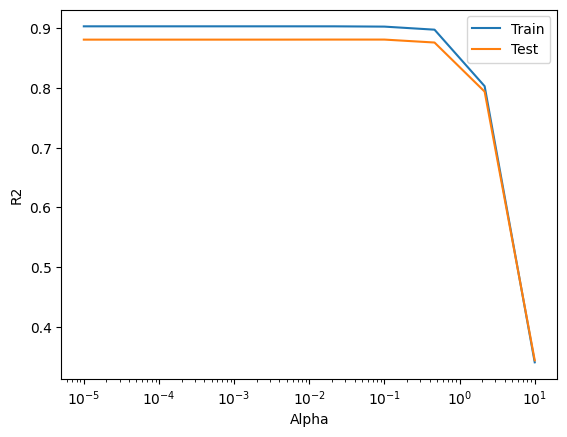

In [264]:
alphas = np.geomspace(1e-5, 10, 10)
r2_trains = []
r2_tests = []
for alpha in alphas:
    result = estimator_evaluation(
        Pipeline([
            ('scaler', StandardScaler()),
            ('model', Lasso(alpha))
        ]),
        f"Lasso Alpha {alpha} Regression",
        do_return=True
    )

    r2_trains.append(result['r2_train'])
    r2_tests.append(result['r2_test'])

ax = plt.gca()
ax.plot(alphas, r2_trains, label='Train')
ax.plot(alphas, r2_tests, label='Test')
ax.set_xscale("log")
plt.xlabel("Alpha")
plt.ylabel("R2")
plt.legend()
plt.show()

The optimal lambda value appears to be around 0.5.

In [265]:
lasso_search = GridSearchCV(
    Pipeline([
        ('scaler', StandardScaler()),
        ('polynomial', PolynomialFeatures(degree=2)),
        ('model', Lasso(max_iter=100000, tol=1e-2))
    ]),
    {
        'polynomial__degree': [1, 2, 3],
        'model__alpha': np.geomspace(1e-5, 1, 5)
    },
    n_jobs=2
).fit(X_train, y_train)

print(lasso_search.best_params_)
estimator_evaluation(lasso_search, "Lasso Cross Validated", do_fit=False)


{'model__alpha': np.float64(0.05623413251903491), 'polynomial__degree': 1}
Lasso Cross Validated - R2 Train: 0.9028098982177133
Lasso Cross Validated - R2 Test: 0.8808567992486543


Through cross-validation grid search, the best settings for Lasso were determined to be a lambda of 0.05 with a polynomial degree of 1.

Ridge Alpha 1e-05 Regression - R2 Train: 0.9029717381660443
Ridge Alpha 1e-05 Regression - R2 Test: 0.8806849002382837
Ridge Alpha 5.994842503189409e-05 Regression - R2 Train: 0.9029717381660405
Ridge Alpha 5.994842503189409e-05 Regression - R2 Test: 0.8806848979098146
Ridge Alpha 0.00035938136638046257 Regression - R2 Train: 0.902971738165903
Ridge Alpha 0.00035938136638046257 Regression - R2 Test: 0.8806848839509033
Ridge Alpha 0.0021544346900318843 Regression - R2 Train: 0.9029717381609632
Ridge Alpha 0.0021544346900318843 Regression - R2 Test: 0.8806848002656094
Ridge Alpha 0.01291549665014884 Regression - R2 Train: 0.9029717379834422
Ridge Alpha 0.01291549665014884 Regression - R2 Test: 0.8806842984482242
Ridge Alpha 0.0774263682681127 Regression - R2 Train: 0.9029717316046031
Ridge Alpha 0.0774263682681127 Regression - R2 Test: 0.8806812852011644
Ridge Alpha 0.4641588833612782 Regression - R2 Train: 0.9029715025623728
Ridge Alpha 0.4641588833612782 Regression - R2 Test: 0.8806630

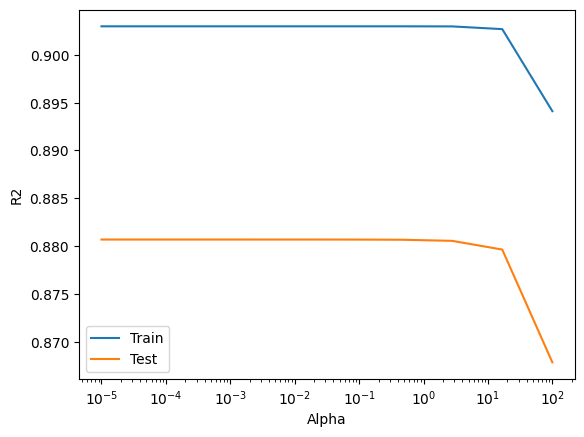

In [266]:
alphas = np.geomspace(1e-5, 100, 10)
r2_trains = []
r2_tests = []
for alpha in alphas:
    result = estimator_evaluation(
        Pipeline([
            ('scaler', StandardScaler()),
            ('model', Ridge(alpha))
        ]),
        f"Ridge Alpha {alpha} Regression",
        do_return=True
    )

    r2_trains.append(result['r2_train'])
    r2_tests.append(result['r2_test'])

ax = plt.gca()
ax.plot(alphas, r2_trains, label='Train')
ax.plot(alphas, r2_tests, label='Test')
ax.set_xscale("log")
plt.xlabel("Alpha")
plt.ylabel("R2")
plt.legend()
plt.show()

The optimal lambda value appears to be approximately 0.5.

In [267]:
ridge_search = GridSearchCV(
    Pipeline([
        ('scaler', StandardScaler()),
        ('polynomial', PolynomialFeatures(degree=2)),
        ('model', Ridge(max_iter=100000, tol=1e-2))
    ]),
    {
        'polynomial__degree': [1, 2, 3],
        'model__alpha': np.geomspace(1e-5, 10, 5)
    },
    n_jobs=2
).fit(X_train, y_train)

print(ridge_search.best_params_)
estimator_evaluation(ridge_search, "Ridge Cross Validated", do_fit=False)

{'model__alpha': np.float64(0.31622776601683794), 'polynomial__degree': 1}
Ridge Cross Validated - R2 Train: 0.9029716287726031
Ridge Cross Validated - R2 Test: 0.8806700574968479


Through cross-validation grid search, the best settings for Ridge regression were confirmed to be a lambda of 0.3 with a polynomial degree of 1.

Ridge Alpha 1e-05 L1 Ratio 0.1 Regression - R2 Train: 0.9029717380923222
Ridge Alpha 1e-05 L1 Ratio 0.1 Regression - R2 Test: 0.8806845226790917
Ridge Alpha 0.0005623413251903491 L1 Ratio 0.1 Regression - R2 Train: 0.9029715049523201
Ridge Alpha 0.0005623413251903491 L1 Ratio 0.1 Regression - R2 Test: 0.8806635749092707
Ridge Alpha 0.03162277660168379 L1 Ratio 0.1 Regression - R2 Train: 0.9022748182594744
Ridge Alpha 0.03162277660168379 L1 Ratio 0.1 Regression - R2 Test: 0.8788629382925441
Ridge Alpha 1.7782794100389228 L1 Ratio 0.1 Regression - R2 Train: 0.5550705360387029
Ridge Alpha 1.7782794100389228 L1 Ratio 0.1 Regression - R2 Test: 0.5201105361347889
Ridge Alpha 100.0 L1 Ratio 0.1 Regression - R2 Train: 0.004371445922196959
Ridge Alpha 100.0 L1 Ratio 0.1 Regression - R2 Test: -0.02858222469086935


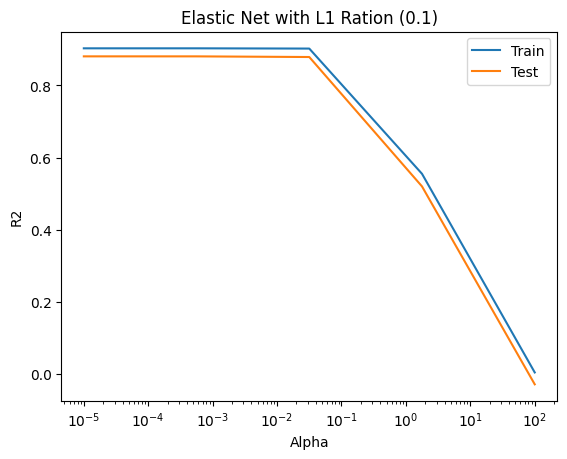

Ridge Alpha 1e-05 L1 Ratio 0.30000000000000004 Regression - R2 Train: 0.9029717381176322
Ridge Alpha 1e-05 L1 Ratio 0.30000000000000004 Regression - R2 Test: 0.8806846243292608
Ridge Alpha 0.0005623413251903491 L1 Ratio 0.30000000000000004 Regression - R2 Train: 0.902971586390186
Ridge Alpha 0.0005623413251903491 L1 Ratio 0.30000000000000004 Regression - R2 Test: 0.8806710244796975
Ridge Alpha 0.03162277660168379 L1 Ratio 0.30000000000000004 Regression - R2 Train: 0.9025084064158431
Ridge Alpha 0.03162277660168379 L1 Ratio 0.30000000000000004 Regression - R2 Test: 0.8793922448149266
Ridge Alpha 1.7782794100389228 L1 Ratio 0.30000000000000004 Regression - R2 Train: 0.5976391576896557
Ridge Alpha 1.7782794100389228 L1 Ratio 0.30000000000000004 Regression - R2 Test: 0.5686564092076292
Ridge Alpha 100.0 L1 Ratio 0.30000000000000004 Regression - R2 Train: 0.0
Ridge Alpha 100.0 L1 Ratio 0.30000000000000004 Regression - R2 Test: -0.03355256609210033


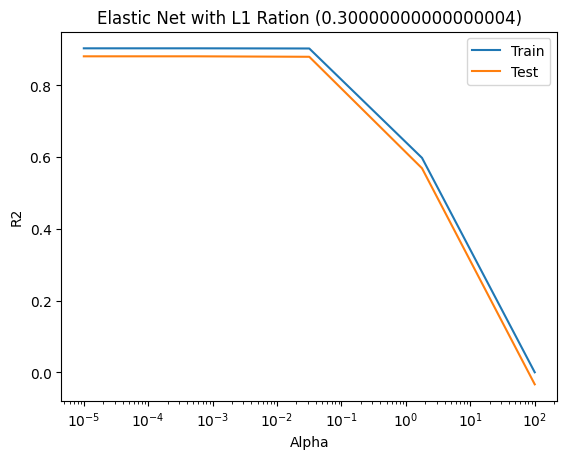

Ridge Alpha 1e-05 L1 Ratio 0.5 Regression - R2 Train: 0.9029717381361118
Ridge Alpha 1e-05 L1 Ratio 0.5 Regression - R2 Test: 0.8806846984784703
Ridge Alpha 0.0005623413251903491 L1 Ratio 0.5 Regression - R2 Train: 0.9029716476675537
Ridge Alpha 0.0005623413251903491 L1 Ratio 0.5 Regression - R2 Test: 0.8806767969638528
Ridge Alpha 0.03162277660168379 L1 Ratio 0.5 Regression - R2 Train: 0.9026912445450925
Ridge Alpha 0.03162277660168379 L1 Ratio 0.5 Regression - R2 Test: 0.8798503776769436
Ridge Alpha 1.7782794100389228 L1 Ratio 0.5 Regression - R2 Train: 0.6512660935896906
Ridge Alpha 1.7782794100389228 L1 Ratio 0.5 Regression - R2 Test: 0.6282649165740641
Ridge Alpha 100.0 L1 Ratio 0.5 Regression - R2 Train: 0.0
Ridge Alpha 100.0 L1 Ratio 0.5 Regression - R2 Test: -0.03355256609210033


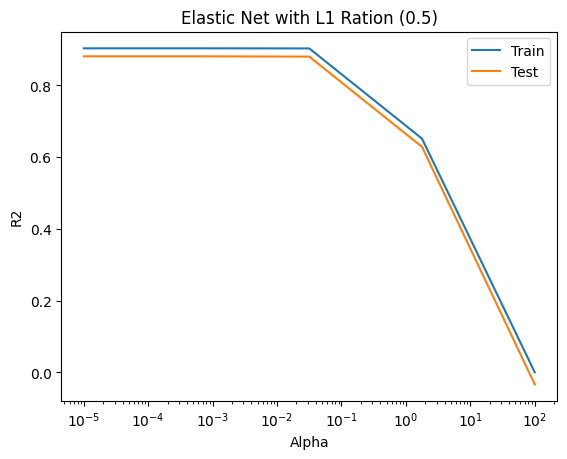

Ridge Alpha 1e-05 L1 Ratio 0.7000000000000001 Regression - R2 Train: 0.9029717381498417
Ridge Alpha 1e-05 L1 Ratio 0.7000000000000001 Regression - R2 Test: 0.8806848001144136
Ridge Alpha 0.0005623413251903491 L1 Ratio 0.7000000000000001 Regression - R2 Train: 0.9029716906308467
Ridge Alpha 0.0005623413251903491 L1 Ratio 0.7000000000000001 Regression - R2 Test: 0.8806825503354706
Ridge Alpha 0.03162277660168379 L1 Ratio 0.7000000000000001 Regression - R2 Train: 0.9028223155068582
Ridge Alpha 0.03162277660168379 L1 Ratio 0.7000000000000001 Regression - R2 Test: 0.8802651885178117
Ridge Alpha 1.7782794100389228 L1 Ratio 0.7000000000000001 Regression - R2 Train: 0.7176722623577767
Ridge Alpha 1.7782794100389228 L1 Ratio 0.7000000000000001 Regression - R2 Test: 0.7009709094770897
Ridge Alpha 100.0 L1 Ratio 0.7000000000000001 Regression - R2 Train: 0.0
Ridge Alpha 100.0 L1 Ratio 0.7000000000000001 Regression - R2 Test: -0.03355256609210033


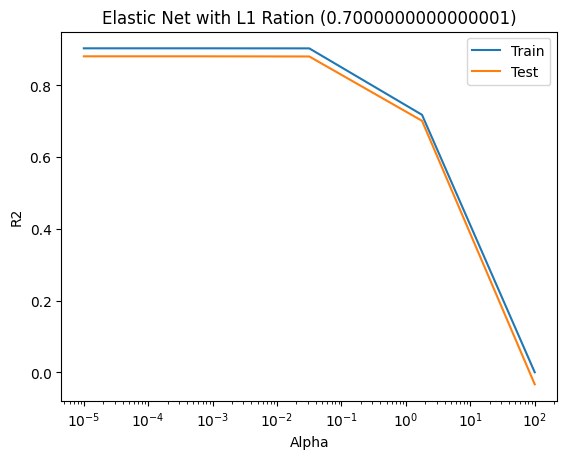

Ridge Alpha 1e-05 L1 Ratio 0.9 Regression - R2 Train: 0.9029717381577697
Ridge Alpha 1e-05 L1 Ratio 0.9 Regression - R2 Test: 0.8806849017443314
Ridge Alpha 0.0005623413251903491 L1 Ratio 0.9 Regression - R2 Train: 0.9029717152677003
Ridge Alpha 0.0005623413251903491 L1 Ratio 0.9 Regression - R2 Test: 0.8806882845809914
Ridge Alpha 0.03162277660168379 L1 Ratio 0.9 Regression - R2 Train: 0.9029007312087325
Ridge Alpha 0.03162277660168379 L1 Ratio 0.9 Regression - R2 Test: 0.880624658698983
Ridge Alpha 1.7782794100389228 L1 Ratio 0.9 Regression - R2 Train: 0.7961345836779083
Ridge Alpha 1.7782794100389228 L1 Ratio 0.9 Regression - R2 Test: 0.783625734010382
Ridge Alpha 100.0 L1 Ratio 0.9 Regression - R2 Train: 0.0
Ridge Alpha 100.0 L1 Ratio 0.9 Regression - R2 Test: -0.03355256609210033


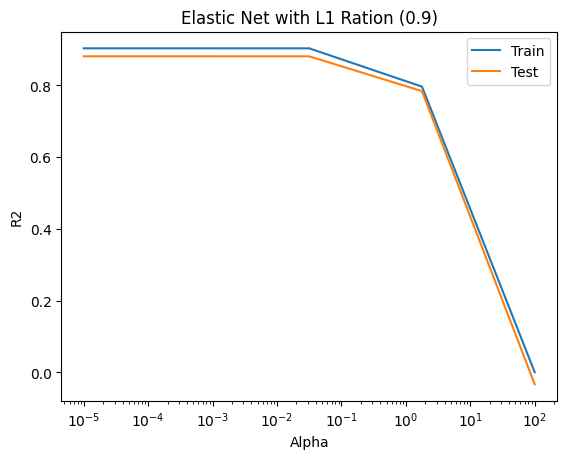

In [268]:
for l1_ratio in np.linspace(0.1, 0.9, 5):
    alphas = np.geomspace(1e-5, 100, 5)
    r2_trains = []
    r2_tests = []
    for alpha in alphas:
        result = estimator_evaluation(
            Pipeline([
                ('scaler', StandardScaler()),
                ('model', ElasticNet(alpha, l1_ratio=l1_ratio, max_iter=100000, tol=1e-2))
            ]),
            f"Ridge Alpha {alpha} L1 Ratio {l1_ratio} Regression",
            do_return=True
        )

        r2_trains.append(result['r2_train'])
        r2_tests.append(result['r2_test'])

    ax = plt.gca()
    ax.plot(alphas, r2_trains, label='Train')
    ax.plot(alphas, r2_tests, label='Test')
    ax.set_xscale("log")
    plt.title(f"Elastic Net with L1 Ration ({l1_ratio})")
    plt.xlabel("Alpha")
    plt.ylabel("R2")
    plt.legend()
    plt.show()

Given that both Lasso and Ridge regression yielded similar R2 results, it is not surprising that Elastic Net also shows comparable top results across all L1 ratios.

In [269]:
elastic_net_search = GridSearchCV(
    Pipeline([
        ('scaler', StandardScaler()),
        ('polynomial', PolynomialFeatures(degree=2)),
        ('model', ElasticNet(max_iter=100000, tol=1e-2))
    ]),
    {
        'polynomial__degree': [1, 2, 3],
        'model__alpha': np.geomspace(1e-5, 10, 5),
        'model__l1_ratio': np.linspace(0.1, 0.9, 5),
    },
    n_jobs=2
).fit(X_train, y_train)

print(elastic_net_search.best_params_)
estimator_evaluation(elastic_net_search, "ElasticNet Cross Validated", do_fit=False)

{'model__alpha': np.float64(0.01), 'model__l1_ratio': np.float64(0.9), 'polynomial__degree': 1}
ElasticNet Cross Validated - R2 Train: 0.9029645887971344
ElasticNet Cross Validated - R2 Test: 0.8806983622436324


The optimal parameters for Elastic Net were found to be an alpha of 0.01, an L1 ratio of 0.9, and a polynomial degree of 1.

Across all models, we observed similar top results, with training R2 scores of 0.9 and testing R2 scores of 0.88. Increasing polynomial degrees generally degraded performance, and regularization models did not outperform standard regression.

In [270]:
def get_R2_features(model,test=True): 
    #X: global  
    features=list(X)
    
    R_2_train=[]
    R_2_test=[]

    for feature in features:
        model.fit(X_train[[feature]],y_train)
        
        R_2_test.append(model.score(X_test[[feature]],y_test))
        R_2_train.append(model.score(X_train[[feature]],y_train))
        
    plt.bar(features,R_2_train,label="Train")
    plt.bar(features,R_2_test,label="Test")
    plt.xticks(rotation=90)
    plt.ylabel("$R^2$")
    plt.legend()
    plt.show()

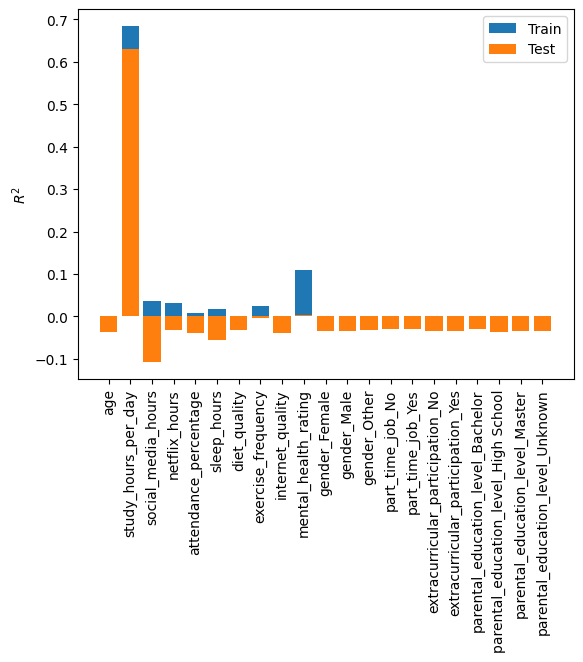

In [271]:
lm = LinearRegression().fit(X_train, y_train)
get_R2_features(lm)

The amount of time a student dedicates to studying is the primary indicator of their academic performance. Mental health ratings and social media usage also exhibit some predictive power, though significantly less than study time.

# 4. Findings & Interpretation

Our analysis indicates that all evaluated regression models (linear, Lasso, Ridge, Elastic Net), even with the inclusion of polynomial features or PCA, yielded comparable R2 performance. Given these findings, standard linear regression emerges as the optimal choice due to its simplicity and computational efficiency, offering accuracy on par with more complex models.

We identified study time as the most influential feature in predicting student exam scores. While social media time and mental health also played a role, their impact was considerably less significant than that of study time. This highlights the paramount importance of dedicated study in academic outcomes.

# 5. Evaluation & Future Steps

Despite achieving good training (R2=0.90) and testing (R2=0.88) scores, we were unable to surpass the performance of standard linear regression with more complex models. This suggests either a strong linear relationship within our dataset or that the current feature set and data volume limit further improvements.

Limitations of this analysis include the potential for uncaptured non-linear relationships, an incomplete feature set, and insufficient data volume.

For future steps, we will explore non-linear models such as Random Forests, Gradient Boosting Machines, and Neural Networks. Additionally, we aim to acquire more data, including supplementary features, and conduct advanced feature engineering and error analysis to uncover latent patterns and enhance our model's predictive capabilities.

Copyright @ IBM Corporation. All rights reserved.
